In [ ]:
import stkan as sk


In [ ]:
SEED = 0                     # Random seed for reproducibility
DATA_DIR = "/home/data1/linjing0806/DuiBi/stKAN/data/DLPFC"   # Directory containing spatial data
SAMPLE_ID = "151507"         # Sample identifier to analyze
N_DOMAINS = 5 if SAMPLE_ID in ['151669', '151670', '151671', '151672'] else 7 # Expected number of spatial domains
sk.fixed(seed=SEED)

In [ ]:
stKAN = sk.executor(
    task="identify",  # Spatial domain identification
    pre_epochs=500,          # Pretraining iterations
    epochs=500,              # Main training iterations
    use_gpu=True             # Accelerate with GPU if available
)

In [4]:
adata = stKAN.get_adata(
    platform="Visium",
    data_path=DATA_DIR,
    data_name=SAMPLE_ID
)
# adata = sc.read_h5ad(DATA_DIR + SAMPLE_ID)
# adata.var_names_make_unique()

/home/data1/linjing0806/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/data1/linjing0806/anaconda3/envs/pytorch_gpu/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
from pathlib import Path
use_image = False
RESULTS_DIR = "./Results"   # Directory to save outputs
if use_image == True:
    save_dir = Path(RESULTS_DIR) / 'Image_crop' / SAMPLE_ID
    save_dir.mkdir(parents=True, exist_ok=True)
    adata = sk.image_crop(adata, save_path=save_dir)
    adata = sk.image_feature(
        adata, 
        pca_components=50, 
        transType='ViT16').extract()

In [7]:
use_morpho = True if use_image else False
adata = sk.augment_adata(adata,
                         adjacent_weight = 0.3,
                         neighbour_k = 4,
                         spatial_k = 30,
                         n_components = 100,
                         md_dist_type = "cosine",
                         gb_dist_type = "correlation",
                         use_morphological = use_morpho,
                         use_data = "raw",
                         spatial_type = "BallTree")


Spatial weights calculated. Average neighbors: 30.0
Gene expression weights calculated.
Final weight matrix calculated and stored in adata.obsm['weight_matrix']


Finding adjacent spots: 100%|██████████ [ time left: 00:00 ]


In [8]:
graph_dict = sk.graph(adata.obsm["spatial"],
                      distType = "KDTree",
                      k = 12).main()


12.0000 neighbors per cell on average.


In [9]:
data = stKAN.data_process(
    adata,
    pca_n_comps=200          # Reduce to 200 principal components
)


In [10]:
stKAN_embed = stKAN.fit(
    data=data,
    graph_dict=graph_dict,
    linear_encoder_hidden=[50, 32],
    linear_decoder_hidden=[50, 20], 
    conv_hidden=[50, 12],
    use_contra=False
)
adata.obsm["stKAN_embed"] = stKAN_embed


Running stKAN analysis...


Pretraining initial model: 100%|██████████ [ time left: 00:00 ]
Training final model: 100%|██████████ [ time left: 00:00 ]

stKAN training completed
Memory usage: 5.09 GB
Total time: 0.90 minutes


In [11]:
adata = stKAN.get_cluster_data(
    adata,
    n_domains=N_DOMAINS,     # Expected number of domains
    priori=True              # Use prior knowledge if available
)


Found resolution: 0.38 for 7 domains


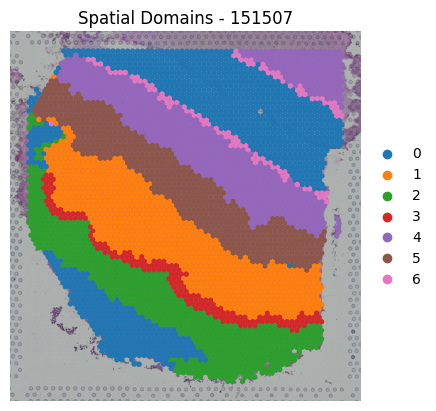

In [ ]:
import scanpy as sc
sc.pl.spatial(
    adata,
    color=["stKAN_refine_domain"],  # Color by domain
    frameon=False,
    spot_size=150,
    title=f"Spatial Domains - {SAMPLE_ID}"
)

In [13]:
adata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'leiden', 'stKAN_domain', 'stKAN_refine_domain'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'neighbors', 'leiden', 'stKAN_domain', 'stKAN_refine_domain_colors'
    obsm: 'spatial', 'weight_matrix', 'adjacent_data', 'augment_gene_data', 'stKAN_embed'
    obsp: 'distances', 'connectivities'

In [ ]:
import pandas as pd
from sklearn import metrics
df_meta = pd.read_csv(DATA_DIR + '/' + SAMPLE_ID + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [15]:
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['stKAN_refine_domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI
print('ARI:', ARI)


/tmp/ipykernel_2907127/1441203488.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


ARI: 0.45752125543469746


In [16]:
NMI = metrics.normalized_mutual_info_score(adata.obs['stKAN_refine_domain'], adata.obs['ground_truth'])
adata.uns['NMI'] = NMI
print('NMI:', NMI)

NMI: 0.6132968496214831


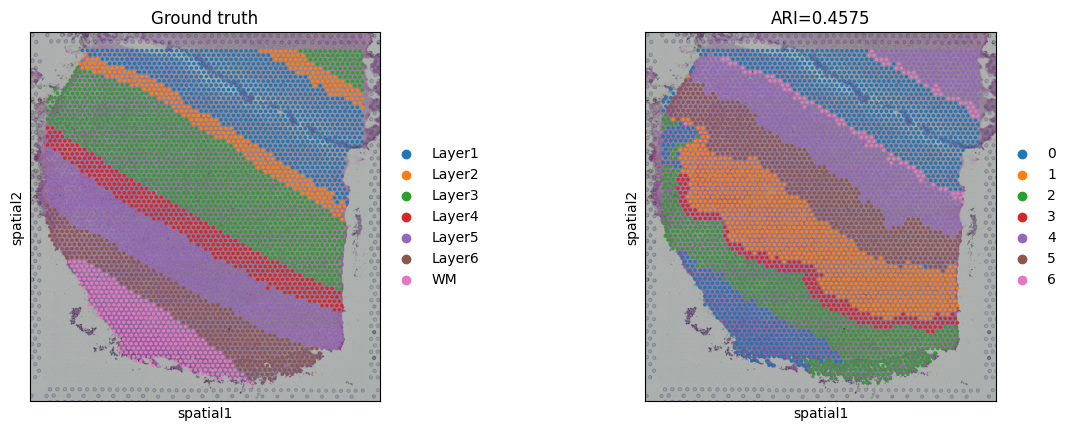

In [17]:
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "stKAN_refine_domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

In [18]:
adata


AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'leiden', 'stKAN_domain', 'stKAN_refine_domain', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'neighbors', 'leiden', 'stKAN_domain', 'stKAN_refine_domain_colors', 'ARI', 'NMI', 'ground_truth_colors'
    obsm: 'spatial', 'weight_matrix', 'adjacent_data', 'augment_gene_data', 'stKAN_embed'
    obsp: 'distances', 'connectivities'

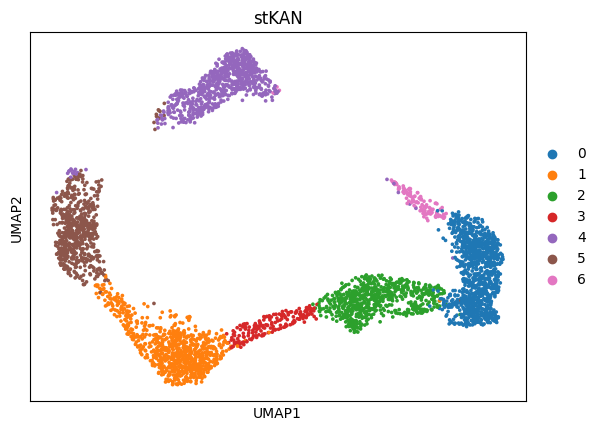

In [19]:
sc.pp.neighbors(adata, use_rep='stKAN_embed')
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color="stKAN_refine_domain",
    title="stKAN"
)


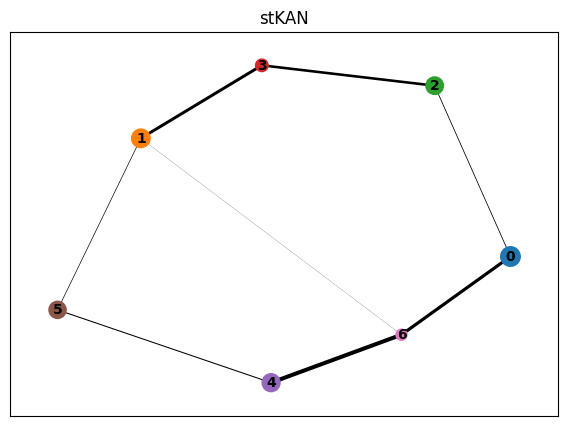

In [20]:
# 计算PAGA图
sc.tl.paga(adata, groups="stKAN_refine_domain")
sc.pl.paga(adata, color="stKAN_refine_domain", title="stKAN")